In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
from statsmodels.stats.diagnostic import lilliefors

In [6]:
# Load additional information
additional_info = pd.read_csv("../data/raw/additional_participants_information.csv")
additional_info.head(2)

,participant name,gender,age,height,weight,foot length,foot width,faller,low stability
0,dida,female,79,156.0,67.0,28.0,11.5,0,0
1,ronald,male,80,176.0,89.0,32.0,12.0,0,0


In [7]:
additional_info["faller"].value_counts()

faller
0    60
1     5
Name: count, dtype: int64

In [8]:
additional_info["low stability"].value_counts()

low stability
0    55
1    10
Name: count, dtype: int64

In [9]:
df = additional_info.copy()

# Define student group (participant name is numeric)
group_students = df[df["participant name"].astype(str).str.isnumeric()]

# Define older adults only
df_older = df[~df["participant name"].astype(str).str.isnumeric()]

# Define low and non-low stability groups among older adults
group_non_low = df_older[df_older["low stability"] == 0]
group_low = df_older[df_older["low stability"] == 1]

# Features to compare
numeric_vars = ["age", "height", "weight", "foot length", "foot width"]
results = []

for var in numeric_vars:
    values_non_low = group_non_low[var].dropna()
    values_low = group_low[var].dropna()
    values_students = group_students[var].dropna()

    # Normality
    _, p0 = lilliefors(values_non_low)
    _, p1 = lilliefors(values_low)
    normal_0 = p0 > 0.05
    normal_1 = p1 > 0.05

    # Test selection between older adults (non-low vs. low stability)
    if normal_0 and normal_1:
        stat, pval = ttest_ind(values_non_low, values_low, equal_var=False)
        test_used = "t-test"
    else:
        stat, pval = mannwhitneyu(values_non_low, values_low, alternative='two-sided')
        test_used = "Mann–Whitney U"

    results.append({
        "Variable": var,
        "Non-Low Stability (Mean ± SEM)": f"{values_non_low.mean():.2f} ± {values_non_low.sem():.2f}",
        "Low Stability (Mean ± SEM)": f"{values_low.mean():.2f} ± {values_low.sem():.2f}",
        "Students (Mean ± SEM)": f"{values_students.mean():.2f} ± {values_students.sem():.2f}",
        "Test Used": test_used,
        "P-Value": f"{pval:.4f}"
    })

# Gender (categorical)
def gender_count(group):
    return (group["gender"] == "female").sum(), (group["gender"] == "male").sum()

female_non_low, male_non_low = gender_count(group_non_low)
female_low, male_low = gender_count(group_low)
female_students, male_students = gender_count(group_students)

# Chi-square between low vs non-low only (older adults)
contingency = pd.crosstab(df_older["gender"], df_older["low stability"])
chi2, pval, _, _ = chi2_contingency(contingency)

results.append({
    "Variable": "gender (female / male)",
    "Non-Low Stability (Mean ± SEM)": f"{female_non_low} / {male_non_low}",
    "Low Stability (Mean ± SEM)": f"{female_low} / {male_low}",
    "Students (Mean ± SEM)": f"{female_students} / {male_students}",
    "Test Used": "Chi-Square",
    "P-Value": f"{pval:.4f}"
})

# Convert to DataFrame
summary_df = pd.DataFrame(results)
summary_df

,Variable,Non-Low Stability (Mean ± SEM),Low Stability (Mean ± SEM),Students (Mean ± SEM),Test Used,P-Value
0,age,74.96 ± 0.81,73.30 ± 1.57,23.78 ± 0.23,Mann–Whitney U,0.1424
1,height,164.61 ± 1.62,163.40 ± 3.42,172.76 ± 1.86,t-test,0.7547
2,weight,72.14 ± 2.48,77.10 ± 3.12,66.13 ± 2.62,t-test,0.2267
3,foot length,28.54 ± 0.42,28.35 ± 0.70,28.48 ± 0.44,t-test,0.8225
4,foot width,11.05 ± 0.23,10.85 ± 0.33,10.61 ± 0.16,t-test,0.6149
5,gender (female / male),14 / 14,6 / 4,16 / 11,Chi-Square,0.8613


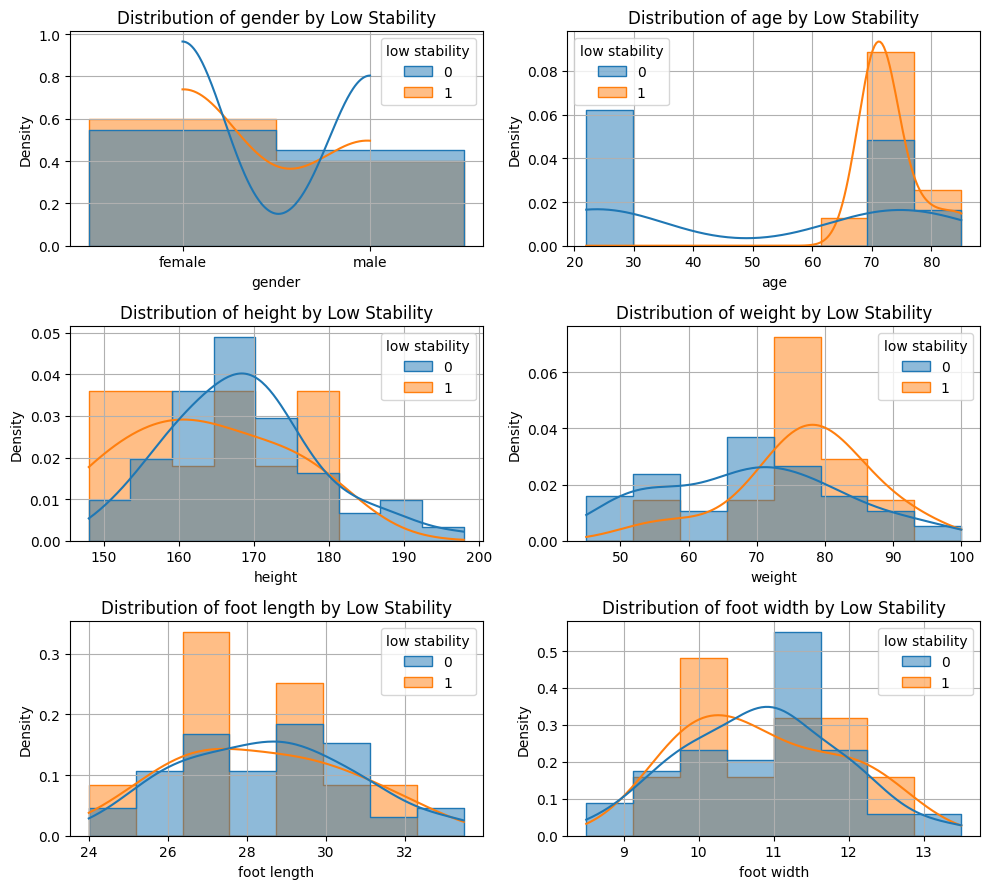

In [10]:
df = additional_info

# Drop irrelevant columns
df = df.drop(columns=["participant name", "faller"])

# Set up the plotting
features = df.columns.drop("low stability")
num_features = len(features)
fig, axes = plt.subplots(nrows=(num_features + 1) // 2, ncols=2, figsize=(10, 3 * ((num_features + 1) // 2)))
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i]
    sns.histplot(data=df, x=feature, hue="low stability", kde=True, element="step", stat="density", common_norm=False, alpha=0.5, ax=ax)
    ax.set_title(f"Distribution of {feature} by Low Stability")
    ax.grid(True)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

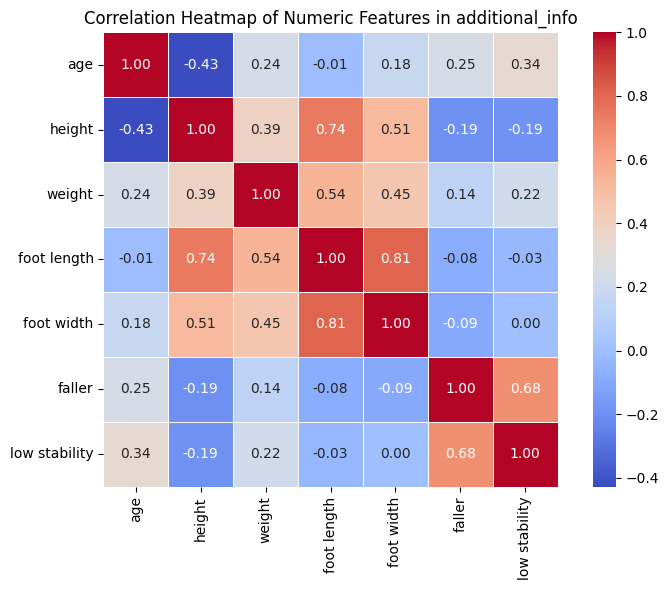

In [11]:
# Select only numeric columns
numeric_df = additional_info.select_dtypes(include='number')

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)

# Title and layout
plt.title("Correlation Heatmap of Numeric Features in additional_info")
plt.tight_layout()
plt.show()